In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from scipy.integrate import solve_ivp

# SEIR model

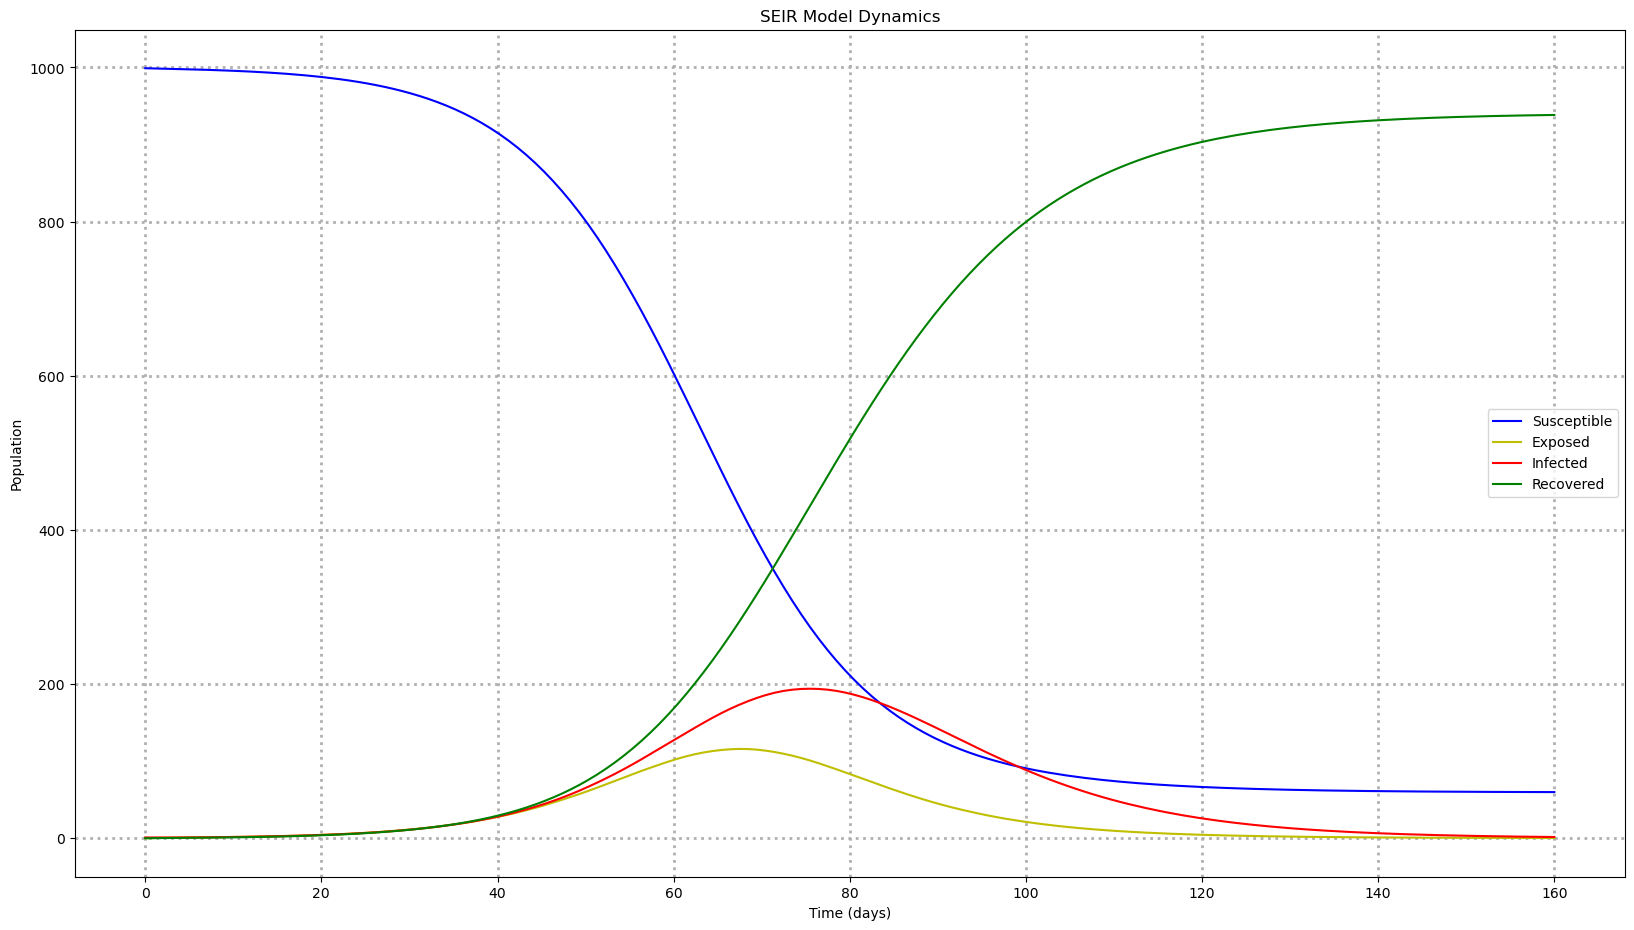

In [4]:
# theotal population we are modeling -  N
N = 1000
# the initial number of infected and recovered individuals in our data
I0, R0 = 1, 0
# the initial number of exposed individuals in our data
E0 = 0
# everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - E0
# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta, sigma, gamma = 0.3, 1/5.2, 1/10
# the time points (days) over which we want to predict using our model
t = np.linspace(0, 160, 160)

# the SEIR model differential equations
def deriv(t, y, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# here we set the initial conditions vector
y0 = S0, E0, I0, R0
# and use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 160], y0, args=(N, beta, sigma, gamma), t_eval=t)

# extract the results
S, E, I, R = sol.y

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(20,11))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, E, 'y', label='Exposed')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()



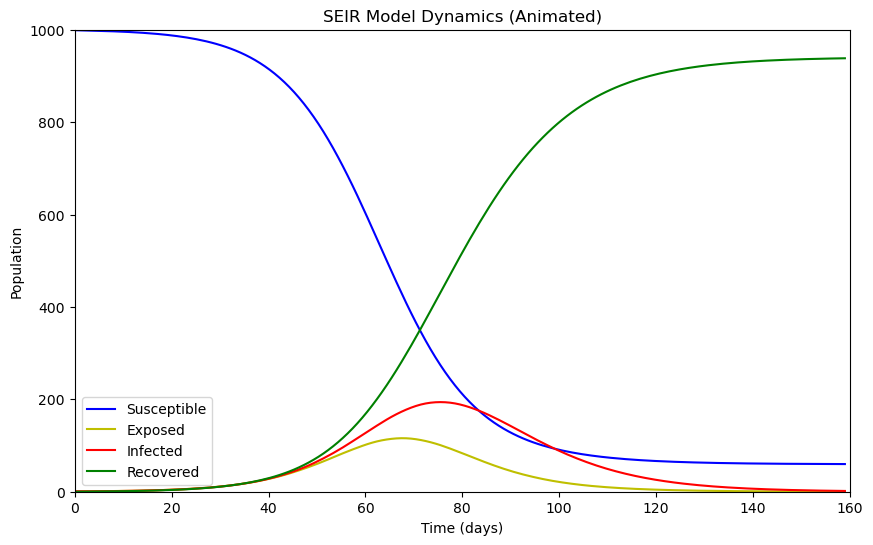

In [7]:
# --- Animation setup -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(t[0], t[-1])
ax.set_ylim(0, N)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("SEIR Model Dynamics (Animated)")

line_S, = ax.plot([], [], 'b', label='Susceptible')
line_E, = ax.plot([], [], 'y', label='Exposed')
line_I, = ax.plot([], [], 'r', label='Infected')
line_R, = ax.plot([], [], 'g', label='Recovered')
ax.legend()

def init():
    for ln in (line_S, line_E, line_I, line_R):
        ln.set_data([], [])
    return line_S, line_E, line_I, line_R

def animate(i):
    # show data up to frame i
    line_S.set_data(t[:i], S[:i])
    line_E.set_data(t[:i], E[:i])
    line_I.set_data(t[:i], I[:i])
    line_R.set_data(t[:i], R[:i])
    return line_S, line_E, line_I, line_R

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(t), blit=True
)


anim.save("/Users/MiladM-Dev/Documents/1PhD/project-sim-ai/beast-simulation/Scripts/seir_animation.mp4", fps=70, extra_args=['-vcodec', 'libx264'])
plt.show()


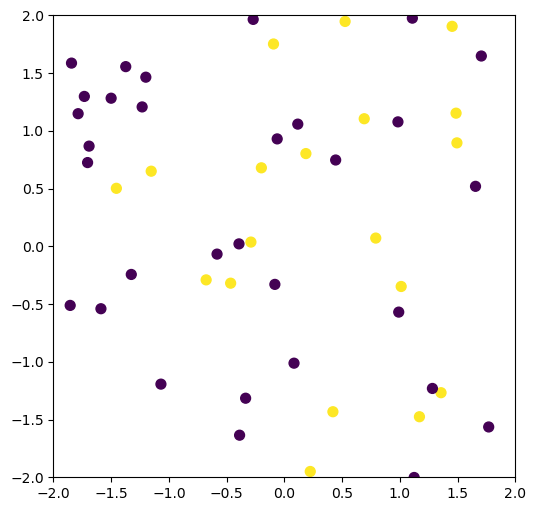

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class SIRParticleBox:
    """SIR model with moving particles"""
    def __init__(self, N=20, bounds=[-2,2,-2,2], size=0.05,
                 infection_radius=2, infection_prob=1, recovery_time=0.1, dt=0.1):
        self.N = N
        self.bounds = bounds
        self.size = size
        self.dt = dt
        self.infection_radius = infection_radius
        self.infection_prob = infection_prob
        self.recovery_time = recovery_time
        
        # Initialize positions and velocities randomly
        self.state = np.zeros((N, 4))  # x, y, vx, vy
        self.state[:, :2] = np.random.uniform([bounds[0], bounds[2]],
                                             [bounds[1], bounds[3]], (N,2))
        self.state[:, 2:] = np.random.uniform(-0.05,0.05,(N,2))
        
        # Infection status: 0=S, 1=I, 2=R
        self.status = np.zeros(N, dtype=int)
        self.infection_time = np.zeros(N)
        
        # Infect a random particle at start
        patient_zero = np.random.randint(N)
        self.status[patient_zero] = 1
        self.infection_time[patient_zero] = 0

    def step(self):
        # Move particles
        self.state[:, :2] += self.state[:, 2:] * self.dt
        
        # Bounce on walls
        crossed_x = (self.state[:,0] < self.bounds[0] + self.size) | \
                    (self.state[:,0] > self.bounds[1] - self.size)
        crossed_y = (self.state[:,1] < self.bounds[2] + self.size) | \
                    (self.state[:,1] > self.bounds[3] - self.size)
        self.state[crossed_x,2] *= -1
        self.state[crossed_y,3] *= -1
        
        # Check for infections
        positions = self.state[:, :2]
        D = squareform(pdist(positions))
        for i in range(self.N):
            if self.status[i] == 1:  # infected
                for j in range(self.N):
                    if self.status[j] == 0 and D[i,j] < self.infection_radius:
                        if np.random.rand() < self.infection_prob:
                            self.status[j] = 1
                            self.infection_time[j] = 0
        
        # Update infection times and recover particles
        self.infection_time[self.status==1] += 1
        recovered = (self.status==1) & (self.infection_time >= self.recovery_time)
        self.status[recovered] = 2

# ---------------- Animation ------------------
N = 50
box = SIRParticleBox(N=N)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(box.bounds[0], box.bounds[1])
ax.set_ylim(box.bounds[2], box.bounds[3])
ax.set_aspect('equal')

scat = ax.scatter(box.state[:,0], box.state[:,1], c=box.status, cmap='viridis', s=50)

def animate(i):
    box.step()
    scat.set_offsets(box.state[:, :2])
    scat.set_array(box.status)
    return scat,

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save("/Users/MiladM-Dev/Documents/1PhD/project-sim-ai/beast-simulation/Scripts/sir_ani_1.mp4", fps=200, extra_args=['-vcodec', 'libx264'])
plt.show()


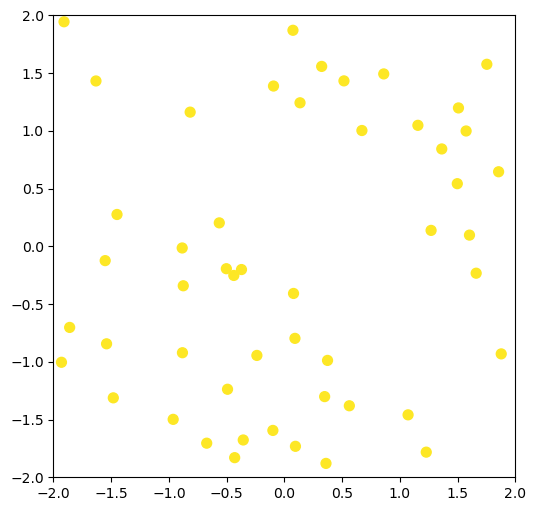

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class SIRParticleBox:
    """SIR model with moving particles"""
    def __init__(self, N=50, bounds=[-2, 2, -2, 2], size=0.05,
                 infection_radius=0.3, infection_prob=1.0,
                 recovery_time=10.0, dt=0.1):
        """
        N               : number of particles
        infection_radius: distance within which infection may occur
        infection_prob  : probability (0–1) of infection per contact
        recovery_time   : time (seconds) to recover
        dt              : simulation time step (seconds)
        """
        self.N = N
        self.bounds = bounds
        self.size = size
        self.dt = dt
        self.infection_radius = infection_radius
        self.infection_prob = infection_prob
        self.recovery_time = recovery_time

        # Positions (x,y) and velocities (vx,vy)
        self.state = np.zeros((N, 4))

        # ---- Place patient zero in the center ----
        self.state[0, :2] = [0, 0]          # x=0, y=0
        self.state[0, 2:] = [0.5, 0.5]       # fixed vx, vy (change as you like)

        self.state[:, :2] = np.random.uniform(
            [bounds[0], bounds[2]],
            [bounds[1], bounds[3]],
            (N, 2)
        )
        self.state[1:, 2:] = np.random.uniform(-0.5, 0.5, (N-1, 2))


        # Infection status: 0=S, 1=I, 2=R
        self.status = np.zeros(N, dtype=int)
        self.infection_time = np.zeros(N)

        # Infect a random particle at start
        patient_zero = np.random.randint(N)
        self.status[patient_zero] = 1
        self.infection_time[patient_zero] = 0

    def step(self):
        # Move particles
        self.state[:, :2] += self.state[:, 2:] * self.dt

        # Bounce on walls
        crossed_x = (self.state[:, 0] < self.bounds[0] + self.size) | \
                    (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y = (self.state[:, 1] < self.bounds[2] + self.size) | \
                    (self.state[:, 1] > self.bounds[3] - self.size)
        self.state[crossed_x, 2] *= -1
        self.state[crossed_y, 3] *= -1

        # Infection spreading
        positions = self.state[:, :2]
        D = squareform(pdist(positions))
        for i in range(self.N):
            if self.status[i] == 1:  # infected
                for j in range(self.N):
                    if self.status[j] == 0 and D[i, j] < self.infection_radius:
                        if np.random.rand() < self.infection_prob:
                            self.status[j] = 1
                            self.infection_time[j] = 0

        # Update infection times using dt and recover
        self.infection_time[self.status == 1] += self.dt
        recovered = (self.status == 1) & (self.infection_time >= self.recovery_time)
        self.status[recovered] = 2


# ---------------- Animation ------------------
box = SIRParticleBox(N=50)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(box.bounds[0], box.bounds[1])
ax.set_ylim(box.bounds[2], box.bounds[3])
ax.set_aspect('equal')

scat = ax.scatter(box.state[:, 0], box.state[:, 1],
                  c=box.status, cmap='viridis', s=50)

def animate(i):
    box.step()
    scat.set_offsets(box.state[:, :2])
    scat.set_array(box.status)
    return scat,

# no blit, so colors update correctly
ani = animation.FuncAnimation(fig, animate,
                              frames=500, interval=50)

# Save at a reasonable frame rate
ani.save(
    "/Users/MiladM-Dev/Documents/1PhD/project-sim-ai/beast-simulation/Scripts/sir_ani_1.mp4",
    fps=30,
    extra_args=['-vcodec', 'libx264']
)

plt.show()


In [ ]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:] #fixed

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = -0.5 + np.random.random((50, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, size=0.04)
dt = 1. / 30 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

ani = animation.FuncAnimation(fig, animate, frames=600,
                              interval=10, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('particle_box.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

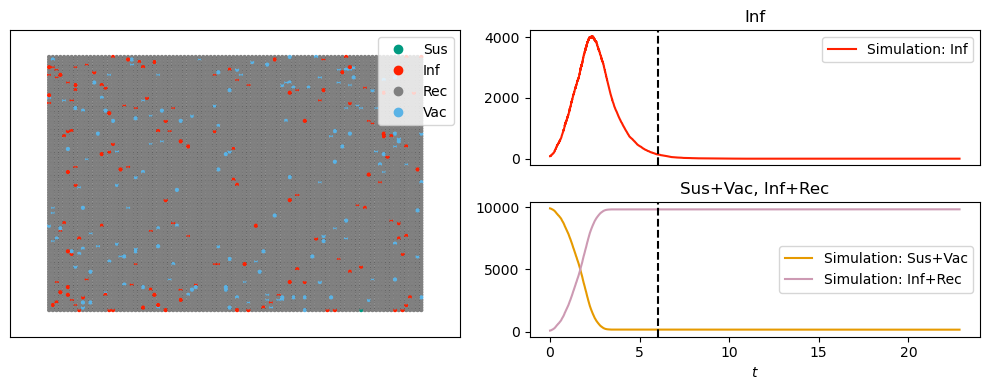

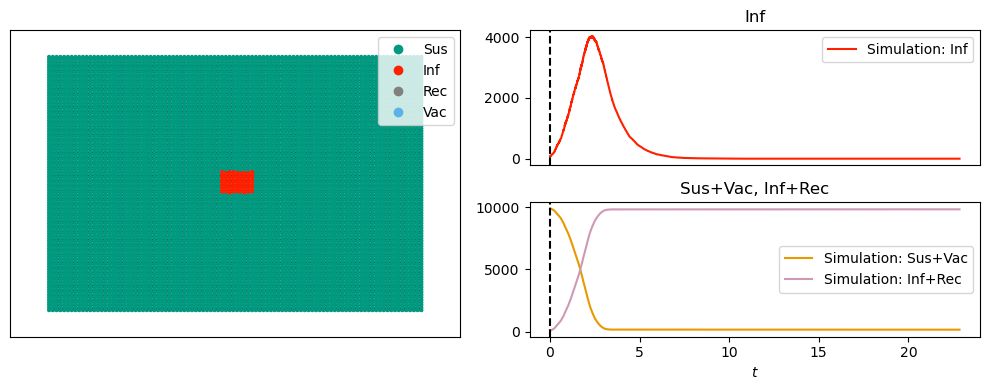

In [42]:
#!pip install EoN
import networkx as nx
import EoN
import matplotlib.pyplot as plt
from collections import defaultdict

G = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99
#we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 45<u<55 and 45<v<55]

H = nx.DiGraph()  #the spontaneous transitions
H.add_edge('Sus', 'Vac', rate = 0.01)
H.add_edge('Inf', 'Rec', rate = 1.0)

J = nx.DiGraph()  #the induced transitions
J.add_edge(('Inf', 'Sus'), ('Inf', 'Inf'), rate = 10.0)

IC = defaultdict(lambda:'Sus')
for node in initial_infections:
    IC[node] = 'Inf'

return_statuses = ['Sus', 'Inf', 'Rec', 'Vac']

color_dict = {'Sus': '#009a80','Inf':'#ff2000', 'Rec':'gray','Vac': '#5AB3E6'}
pos = {node:node for node in G}
tex = False
sim_kwargs = {'color_dict':color_dict, 'pos':pos, 'tex':tex}

sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=30, return_full_data=True, sim_kwargs=sim_kwargs)

times, D = sim.summary()
#
#imes is a numpy array of times.  D is a dict, whose keys are the entries in
#return_statuses.  The values are numpy arrays giving the number in that
#status at the corresponding time.

newD = {'Sus+Vac':D['Sus']+D['Vac'], 'Inf+Rec' : D['Inf'] + D['Rec']}
#
#newD is a new dict giving number not yet infected or the number ever infected
#Let's add this timeseries to the simulation.
#
new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = 'Simulation', color_dict={'Sus+Vac':'#E69A00', 'Inf+Rec':'#CD9AB3'})

sim.display(6, node_size = 4, ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']])
plt.savefig('SIRV_display.png')

ani=sim.animate(ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']], node_size = 4)
ani.save('SIRV_animate.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

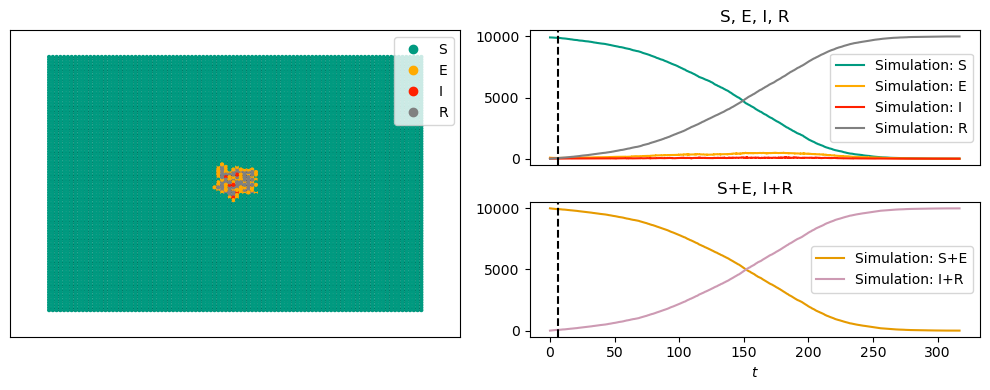

In [44]:
#!pip install EoN
import networkx as nx
import EoN
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1. Create a grid network
G = nx.grid_2d_graph(100,100)

# Initially infect nodes near the middle
initial_infections = [(u,v) for (u,v) in G if 45<u<55 and 45<v<55]

# --- 2. Define spontaneous transitions
# E -> I (latent period ends)
# I -> R (recovery)
H = nx.DiGraph()
H.add_edge('E', 'I', rate=0.14)   # incubation ends
H.add_edge('I', 'R', rate=0.83)   # recovery

# --- 3. Define induced transitions (infection spread)
# (Infected node, Susceptible neighbor) -> (Infected node, Exposed neighbor)
J = nx.DiGraph()
J.add_edge(('I', 'S'), ('I', 'E'), rate=10)

# --- 4. Initial conditions
IC = defaultdict(lambda: 'S')
for node in initial_infections:
    IC[node] = 'E'

return_statuses = ['S', 'E', 'I', 'R']

# --- 5. Colors for visualization
color_dict = {'S':'#009a80', 'E':'#ffaa00', 'I':'#ff2000', 'R':'gray'}
pos = {node:node for node in G}
tex = False
sim_kwargs = {'color_dict':color_dict, 'pos':pos, 'tex':tex}

# --- 6. Run simulation
sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=600, return_full_data=True, sim_kwargs=sim_kwargs)

# --- 7. Summary & combine for plotting
times, D = sim.summary()
newD = {'S+E': D['S'] + D['E'], 'I+R': D['I'] + D['R']}
new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label='Simulation', color_dict={'S+E':'#E69A00', 'I+R':'#CD9AB3'})

# --- 8. Display and save
sim.display(6, node_size=4, ts_plots=[[ 'S','E','I', 'R'], ['S+E', 'I+R']])
plt.savefig('SEIR_display.png')

#ani = sim.animate(ts_plots=[[ 'S','E','I', 'R'], ['S+E', 'I+R']], node_size=4)
#ani.save('SEIR_animate.mp4', fps=100, extra_args=['-vcodec', 'libx264'])


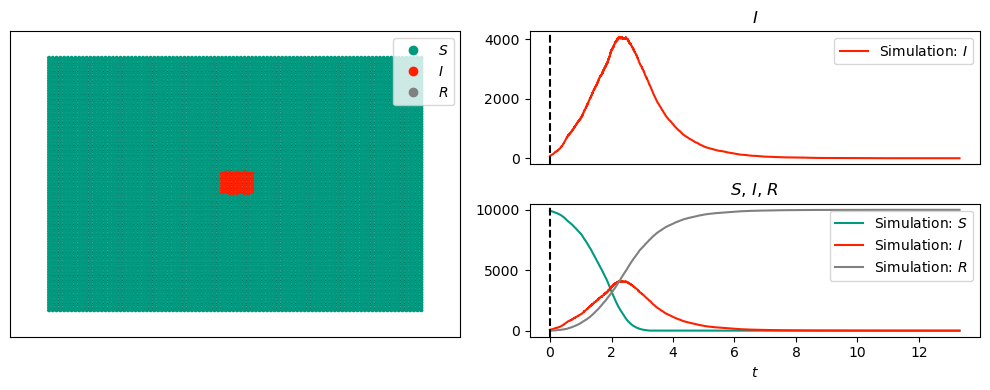

In [45]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
G = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99
#we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 45<u<55 and 45<v<55]
pos = {node:node for node in G}
sim_kwargs = {'pos': pos}
sim = EoN.fast_SIR(G, 10.0, 1.0, initial_infecteds = initial_infections,
               tmax = 40, return_full_data=True, sim_kwargs = sim_kwargs)

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('SIR_2dgrid.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

In [87]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ----------------------------------------------------------
# Particle-based SIR model
# ----------------------------------------------------------
class SIRParticleBox:
    def __init__(self, N=1000, bounds=[-2, 2, -2, 2], size=0.05,
                 infection_radius=0.3, infection_prob=1.0,
                 recovery_time=10.0, dt=0.1):
        self.N = N
        self.bounds = bounds
        self.size = size
        self.dt = dt
        self.infection_radius = infection_radius
        self.infection_prob = infection_prob
        self.recovery_time = recovery_time

        # x, y, vx, vy
        self.state = np.zeros((N, 4))

        # centre patient-zero
        self.state[0, :2] = [0, 0]
        self.state[0, 2:] = [0.1, 0.1]

        # other particles random pos & faster speed
        self.state[1:, :2] = np.random.uniform(
            [bounds[0], bounds[2]],
            [bounds[1], bounds[3]],
            (N-1, 2)
        )
        self.state[1:, 2:] = np.random.uniform(-0.3, 0.3, (N-1, 2))

        self.status = np.zeros(N, dtype=int)   # 0=S,1=I,2=R
        self.infection_time = np.zeros(N)

        # patient zero infected
        self.status[0] = 1

    def step(self):
        self.state[:, :2] += self.state[:, 2:] * self.dt

        # bounce on walls
        crossed_x = (self.state[:, 0] < self.bounds[0] + self.size) | \
                    (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y = (self.state[:, 1] < self.bounds[2] + self.size) | \
                    (self.state[:, 1] > self.bounds[3] - self.size)
        self.state[crossed_x, 2] *= -1
        self.state[crossed_y, 3] *= -1

        # infection
        D = squareform(pdist(self.state[:, :2]))
        for i in range(self.N):
            if self.status[i] == 1:
                for j in range(self.N):
                    if self.status[j] == 0 and D[i, j] < self.infection_radius:
                        if np.random.rand() < self.infection_prob:
                            self.status[j] = 1
                            self.infection_time[j] = 0

        # recovery
        self.infection_time[self.status == 1] += self.dt
        recovered = (self.status == 1) & (self.infection_time >= self.recovery_time)
        self.status[recovered] = 2


# ----------------------------------------------------------
# Set up simulation
# ----------------------------------------------------------
box = SIRParticleBox(N=1000)
steps = 600                     # number of time steps
times = np.arange(0, steps*box.dt, box.dt)

# arrays for S,I,R counts
S_hist, I_hist, R_hist = [], [], []

# ----------------------------------------------------------
# Create figure with two panels: particles + curves
# ----------------------------------------------------------
fig, (ax_particles, ax_curves) = plt.subplots(1, 2, figsize=(12, 6))

# --- left panel: moving particles ---
ax_particles.set_xlim(box.bounds[0], box.bounds[1])
ax_particles.set_ylim(box.bounds[2], box.bounds[3])
ax_particles.set_aspect('equal')
scat = ax_particles.scatter(box.state[:,0], box.state[:,1],
                            c=box.status, cmap='viridis', s=50)
ax_particles.set_title("Particle Spread")

# --- right panel: S,I,R curves ---
ax_curves.set_xlim(0, times[-1])
ax_curves.set_ylim(0, box.N)
ax_curves.set_xlabel("Time (arbitrary units)")
ax_curves.set_ylabel("Population")

line_S, = ax_curves.plot([], [], 'b', label='Susceptible')
line_I, = ax_curves.plot([], [], 'r', label='Infected')
line_R, = ax_curves.plot([], [], 'g', label='Recovered')
ax_curves.legend()
ax_curves.set_title("Population Counts")

# ----------------------------------------------------------
def animate(frame):
    box.step()

    S_hist.append(np.sum(box.status == 0))
    I_hist.append(np.sum(box.status == 1))
    R_hist.append(np.sum(box.status == 2))

    # Use the actual number of collected points
    n = len(S_hist)

    scat.set_offsets(box.state[:, :2])
    scat.set_array(box.status)

    line_S.set_data(times[:n], S_hist[:n])
    line_I.set_data(times[:n], I_hist[:n])
    line_R.set_data(times[:n], R_hist[:n])
    return scat, line_S, line_I, line_R


ani = animation.FuncAnimation(
    fig, animate, frames=steps, interval=50, blit=False
)

# save or just show
ani.save("sir_combined.mp4", fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (600,) and arg 1 with shape (601,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (600,) and arg 1 with shape (601,).

<Figure size 1200x600 with 2 Axes>

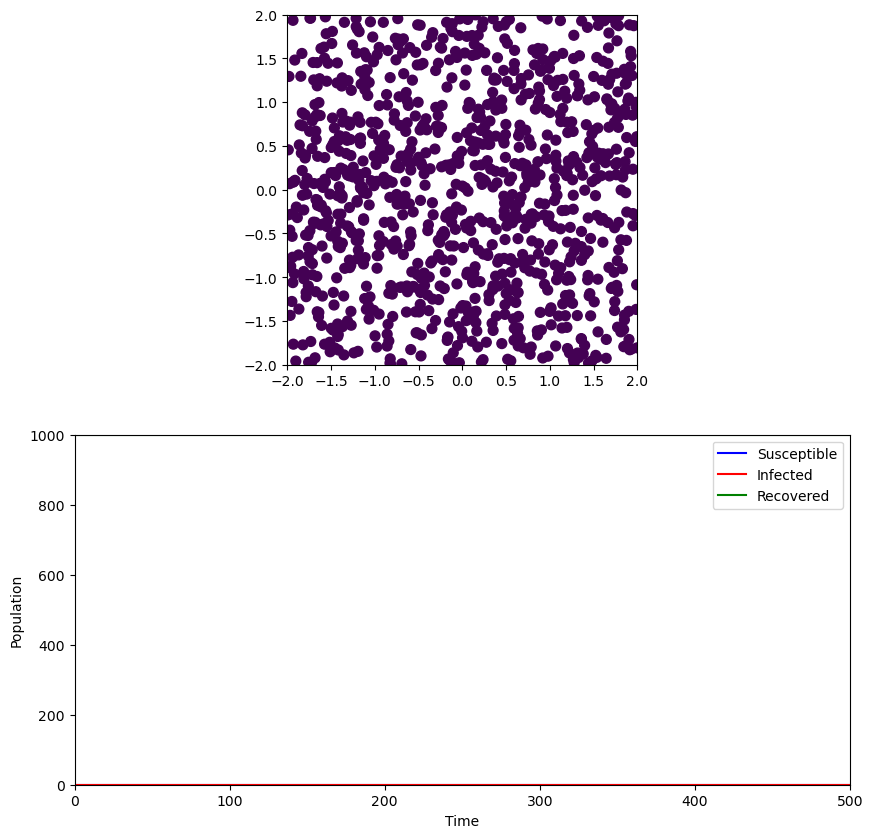

In [88]:
# Initialize empty lists for counts
S_hist, I_hist, R_hist = [], [], []

fig, (ax_particles, ax_curves) = plt.subplots(2, 1, figsize=(10, 10))

# Particle plot
scat = ax_particles.scatter(box.state[:, 0], box.state[:, 1],
                            c=box.status, cmap='viridis', s=50)
ax_particles.set_xlim(box.bounds[0], box.bounds[1])
ax_particles.set_ylim(box.bounds[2], box.bounds[3])
ax_particles.set_aspect('equal')

# Time series plot
line_S, = ax_curves.plot([], [], 'b', label='Susceptible')
line_I, = ax_curves.plot([], [], 'r', label='Infected')
line_R, = ax_curves.plot([], [], 'g', label='Recovered')
ax_curves.set_xlim(0, 500)  # or total frames
ax_curves.set_ylim(0, box.N)
ax_curves.set_xlabel("Time")
ax_curves.set_ylabel("Population")
ax_curves.legend()

def animate(frame):
    box.step()

    # Update counts
    S_hist.append(np.sum(box.status == 0))
    I_hist.append(np.sum(box.status == 1))
    R_hist.append(np.sum(box.status == 2))

    # Update particle positions/colors
    scat.set_offsets(box.state[:, :2])
    scat.set_array(box.status)

    # Update curves (slice by length to avoid shape mismatch)
    n = len(S_hist)
    line_S.set_data(range(n), S_hist)
    line_I.set_data(range(n), I_hist)
    line_R.set_data(range(n), R_hist)

    return scat, line_S, line_I, line_R

ani = animation.FuncAnimation(
    fig, animate, frames=500, interval=50, blit=True
)
ani.save("sir_combined_v2.mp4", fps=30, extra_args=['-vcodec', 'libx264'])

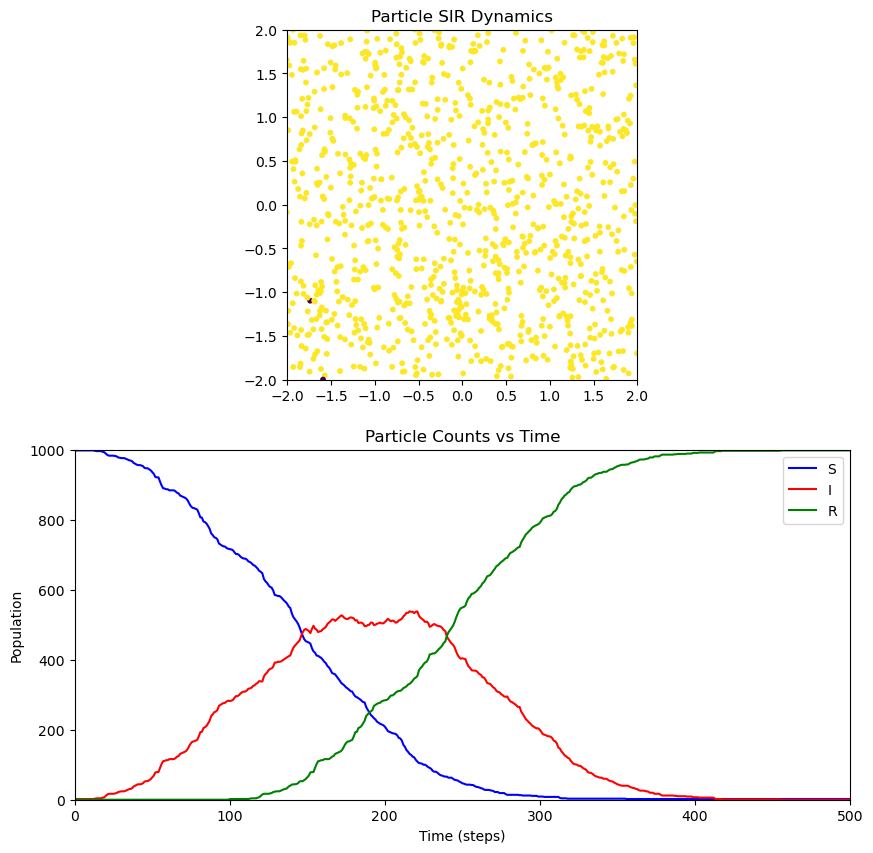

In [94]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ---------------- SEIR ODE Model ----------------
N = 1000
I0, R0, E0 = 1, 0, 0
S0 = N - I0 - R0 - E0
beta, sigma, gamma = 0.1, 1/5.2, 1/10
t = np.linspace(0, 160, 160)

def deriv(t, y, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

y0 = S0, E0, I0, R0
sol = solve_ivp(deriv, [0, 160], y0, args=(N, beta, sigma, gamma), t_eval=t)
S, E, I, R = sol.y

# ---------------- Particle SIR Model ----------------
class SIRParticleBox:
    def __init__(self, N=1000, I0=1, bounds=[-2,2,-2,2], size=0.05,
                 infection_radius=0.1, infection_prob=1.0,
                 recovery_time=1/gamma, dt=0.1):
        self.N = N
        self.bounds = bounds
        self.size = size
        self.dt = dt
        self.infection_radius = infection_radius
        self.infection_prob = infection_prob
        self.recovery_time = recovery_time

        self.state = np.zeros((N,4))
        self.state[:, :2] = np.random.uniform([bounds[0], bounds[2]], 
                                              [bounds[1], bounds[3]], (N,2))
        # velocities: make susceptible particles faster
        self.state[1:, 2:] = np.random.uniform(-0.1,0.1,(N-1,2))
        # patient zero in center, slow for visibility
        self.state[0, :2] = [0,0]
        self.state[0, 2:] = [0.2, 0.2]

        self.status = np.zeros(N, dtype=int)
        self.infection_time = np.zeros(N)
        # Infect I0 particles
        infected_indices = np.random.choice(N, I0, replace=False)
        self.status[infected_indices] = 1

    def step(self):
        # Move particles
        self.state[:, :2] += self.state[:, 2:] * self.dt

        # Bounce on walls
        crossed_x = (self.state[:,0] < self.bounds[0]+self.size) | (self.state[:,0] > self.bounds[1]-self.size)
        crossed_y = (self.state[:,1] < self.bounds[2]+self.size) | (self.state[:,1] > self.bounds[3]-self.size)
        self.state[crossed_x,2] *= -1
        self.state[crossed_y,3] *= -1

        # Infection spread
        D = squareform(pdist(self.state[:, :2]))
        for i in range(self.N):
            if self.status[i]==1:
                for j in range(self.N):
                    if self.status[j]==0 and D[i,j]<self.infection_radius:
                        if np.random.rand()<self.infection_prob:
                            self.status[j]=1
                            self.infection_time[j]=0

        # Recover
        self.infection_time[self.status==1] += self.dt
        recovered = (self.status==1) & (self.infection_time >= self.recovery_time)
        self.status[recovered] = 2

# ---------------- Animation ----------------
box = SIRParticleBox(N=N, I0=I0)

fig, (ax_particles, ax_curves) = plt.subplots(2,1, figsize=(10,10))

# Particle scatter plot
scat = ax_particles.scatter(box.state[:,0], box.state[:,1], c=box.status, cmap='viridis', s=10)
ax_particles.set_xlim(box.bounds[0], box.bounds[1])
ax_particles.set_ylim(box.bounds[2], box.bounds[3])
ax_particles.set_aspect('equal')
ax_particles.set_title("Particle SIR Dynamics")

# SIR curves plot
line_S, = ax_curves.plot([], [], 'b', label='S')
line_I, = ax_curves.plot([], [], 'r', label='I')
line_R, = ax_curves.plot([], [], 'g', label='R')
ax_curves.set_xlim(0, 500)
ax_curves.set_ylim(0, N)
ax_curves.set_xlabel("Time (steps)")
ax_curves.set_ylabel("Population")
ax_curves.legend()
ax_curves.set_title("Particle Counts vs Time")

# History lists
S_hist, I_hist, R_hist = [], [], []

def animate(frame):
    box.step()
    # Update particle plot
    scat.set_offsets(box.state[:, :2])
    scat.set_array(box.status)

    # Update counts
    S_hist.append(np.sum(box.status==0))
    I_hist.append(np.sum(box.status==1))
    R_hist.append(np.sum(box.status==2))

    n = len(S_hist)
    line_S.set_data(range(n), S_hist)
    line_I.set_data(range(n), I_hist)
    line_R.set_data(range(n), R_hist)

    return scat, line_S, line_I, line_R

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save("seir_combined.mp4", fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

